In [8]:
import matplotlib.pyplot as plt
import deorbit.data_models
from deorbit.predictor import EKF
from deorbit.utils.dataio import load_sim_data, load_sim_config
import numpy as np
from deorbit.observer import Observer
from deorbit.utils.constants import EARTH_RADIUS


In [2]:
save_path = "eg/EKF_example_3D/"

sim_data = load_sim_data(save_path)
sim_config = load_sim_config(save_path)


if sim_data is None or sim_config is None:
    np.random.seed(0)
    sim = deorbit.simulator.run(
        "RK4",
        "coesa_atmos_fast",
        initial_state=np.array((deorbit.constants.EARTH_RADIUS + 150000, 0, 0, 0, 0, 7820)),
        noise_types = {"gaussian": {"noise_strength": 0.005}, "impulse": {"impulse_strength": 0.03, "impulse_probability": 1e-5}},
        time_step=0.1,
    )
    sim_data = sim.gather_data()
    sim_config = sim.export_config()
    sim.save_data(save_path)
else:
    print("Loaded data from file")

Loaded data from file


In [3]:
#initialising observer class with sim data
obs = Observer(number_of_radars=3, dim=3)

sim_states = sim_data.state_array()
sim_times = sim_data.times

obs.run(sim_states=sim_states, sim_times=sim_times, checking_interval=1200)

observation_times = obs.observed_times
observation_states = obs.observed_states
observed_covariances = obs.observed_covariances

observations = (observation_states, observation_times)
#dim = sim_data.state_array().shape[1]



In [6]:


# Define process and measurement noise covariance matrices, think this noise should be alot bigger
Q = np.diag([0.1, 0.1, 0.1, 0.01, 0.01, 0.01])#process noise
P = np.eye(sim_data.state_array().shape[1]) #error covariance matrix - represents uncertainty in state estimation

# Measurement matrix H (assuming all states are measured directly??????) -- for now
H = np.eye(sim_data.state_array().shape[1])

dt = sim_config.simulation_method_kwargs.time_step

#initialising 3D EKF
ekf = EKF(dim=3)

estimated_traj, uncertainties, estimated_times = ekf.run(observations, dt=dt, Q=Q, R=observed_covariances, P=P, H=H)

 40%|████      | 2/5 [00:06<00:09,  3.26s/it]


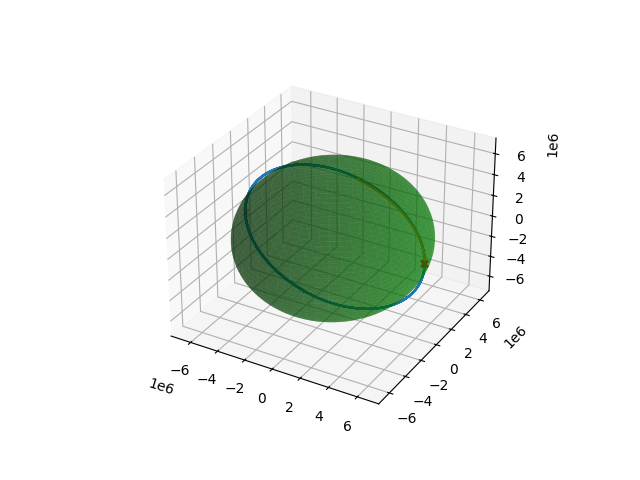

In [16]:
%matplotlib widget
fig = plt.figure()

ax = fig.add_subplot(111, projection="3d")

#plotting EARTH
r = EARTH_RADIUS

theta = np.linspace(0, 2 * np.pi, 100)
phi = np.linspace(0, np.pi, 100)
theta, phi = np.meshgrid(theta, phi)

x = r * np.sin(phi) * np.cos(theta)
y = r * np.sin(phi) * np.sin(theta)
z = r * np.cos(phi)

ax.plot_surface(x, y, z, color="g", alpha=0.5)

#plotting simulated 'true' trajectory
true_traj = sim_data.state_array()[:, :3]
ax.plot(true_traj[:, 0], true_traj[:, 1], true_traj[:, 2], label='True Trajectory')

#plotting observations
ax.scatter(observation_states[:, 0], observation_states[:, 1], observation_states[:, 1], marker='x', color='r', label='Noisy Measurements', s=20)

#plotting prediction
ax.plot(estimated_traj[:, 0], estimated_traj[:, 1], estimated_traj[:, 2], label = 'Estimated Trajectory')

plt.show()
